In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
cd ~/cdv

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import e3nn_jax as e3nn

ir_in = '128x0e'
hidden = '128x0e + 64x1e + 32x2e'
gate_in = '128x0e + 96x0e + 64x1e + 32x2e'
filter_ir = '0e + 1e + 2e'

e3nn.FunctionalLinear(ir_in, hidden)

FunctionalLinear(128x0e -> 128x0e+64x1e+32x2e, 1 instructions, 16384 weights)

In [4]:
from facet.utils import debug_structure


ckpt = np.load('precomputed/sevennet_ckpt.npy', allow_pickle=True).item()

debug_structure({k: v for k, v in ckpt.items() if v.size > 10_000});

sum(x.size for x in jax.tree.leaves(ckpt))

arg0
├── 0_convolution.weight_nn.layer2.weight
│   └── f32[64, 384]
├── 0_self_connection_intro.linear.weight
│   └── f32[28672]
├── 0_self_interaction_1.linear.weight
│   └── f32[16384]
├── 0_self_interaction_2.linear.weight
│   └── f32[40960]
├── 1_convolution.weight_nn.layer2.weight
│   └── f32[64, 960]
├── 1_self_connection_intro.linear.weight
│   └── f32[33792]
├── 1_self_interaction_1.linear.weight
│   └── f32[21504]
├── 1_self_interaction_2.linear.weight
│   └── f32[86016]
├── 2_convolution.weight_nn.layer2.weight
│   └── f32[64, 960]
├── 2_self_connection_intro.linear.weight
│   └── f32[33792]
├── 2_self_interaction_1.linear.weight
│   └── f32[21504]
├── 2_self_interaction_2.linear.weight
│   └── f32[86016]
├── 3_convolution.weight_nn.layer2.weight
│   └── f32[64, 960]
├── 3_self_connection_intro.linear.weight
│   └── f32[33792]
├── 3_self_interaction_1.linear.weight
│   └── f32[21504]
├── 3_self_interaction_2.linear.weight
│   └── f32[86016]
├── 4_convolution.weight_nn.layer2.weight
│   └── f32[64, 224]
├── 4_self_connection_intro.linear.weight
│   └── f32[16384]
├── 4_self_interaction_1.linear.weight
│   └── f32[21504]
├── 4_self_interaction_2.linear.weight
│   └── f32[28672]
└── onehot_to_feature_x.linear.weight
    └── f32[11392]

863456

In [19]:
from pathlib import Path
from facet.layers import Context
import pyrallis
from facet.config import MainConfig
import orbax.checkpoint as ocp

from facet.training_state import TrainingRun
from facet.checkpointing import best_ckpt




conf_file = 'configs/sevennet.toml'

with open(conf_file) as f:
    config = pyrallis.cfgparsing.load(MainConfig, f)

from facet.data.dataset import load_file

config.data.dataset_name = 'mp2022'
cgs = []
for i in range(10):
    cgs.append(load_file(config, group_num=14, file_num=i))

cg = sum(cgs[1:], start=cgs[0])

model = config.build_regressor()

params = model.init(jax.random.key(29205), cg=cg, ctx=Context(training=True))

param_size = sum(x.size for x in jax.tree.leaves(params))
param_size

842748

In [20]:
def is_module(x):
    return isinstance(x, dict) and len(x) > 0 and all(isinstance(c, jax.Array) for c in x.values())

def count(x):
    return sum(c.size for c in x.values())

jax.tree.map(count, params, is_leaf=is_module)


{
    'params': {
        'edge_embedding': {'basis': 8},
        'head': {'Dense_0': 8192, 'Dense_1': 64},
        'mace': {
            'layer_0': {
                'interaction': {
                    'SimpleInteraction_0': {
                        'SevenNetConv_0': {
                            'LazyInMLP_0': {'Dense_0': 512, 'Dense_1': 4096, 'Dense_2': 24576}
                        },
                        'linear_intro': 16384,
                        'linear_outro': 40960
                    },
                    'resid_adapter': 28672
                }
            },
            'layer_1': {
                'interaction': {
                    'SimpleInteraction_0': {
                        'SevenNetConv_0': {
                            'LazyInMLP_0': {'Dense_0': 512, 'Dense_1': 4096, 'Dense_2': 61440}
                        },
                        'linear_intro': 21504,
                        'linear_outro': 86016
                    },
                    'resid_

In [21]:
ckpt_filter = {k: v for k, v in ckpt.items() if 'output_mask' not in k and '_compiled_' not in k and 'denominator' not in k and v.size > 0}
ckpt_size = sum(v.size for k, v in ckpt_filter.items())
print(ckpt_size)
debug_structure(ckpt_filter);

842618


arg0
├── 0_convolution.weight_nn.layer0.weight
│   └── f32[8, 64]
├── 0_convolution.weight_nn.layer1.weight
│   └── f32[64, 64]
├── 0_convolution.weight_nn.layer2.weight
│   └── f32[64, 384]
├── 0_self_connection_intro.linear.weight
│   └── f32[28672]
├── 0_self_interaction_1.linear.weight
│   └── f32[16384]
├── 0_self_interaction_2.linear.weight
│   └── f32[40960]
├── 1_convolution.weight_nn.layer0.weight
│   └── f32[8, 64]
├── 1_convolution.weight_nn.layer1.weight
│   └── f32[64, 64]
├── 1_convolution.weight_nn.layer2.weight
│   └── f32[64, 960]
├── 1_self_connection_intro.linear.weight
│   └── f32[33792]
├── 1_self_interaction_1.linear.weight
│   └── f32[21504]
├── 1_self_interaction_2.linear.weight
│   └── f32[86016]
├── 2_convolution.weight_nn.layer0.weight
│   └── f32[8, 64]
├── 2_convolution.weight_nn.layer1.weight
│   └── f32[64, 64]
├── 2_convolution.weight_nn.layer2.weight
│   └── f32[64, 960]
├── 2_self_connection_intro.linear.weight
│   └── f32[33792]
├── 2_self_interaction_1.linear.weight
│   └── f32[21504]
├── 2_self_interaction_2.linear.weight
│   └── f32[86016]
├── 3_convolution.weight_nn.layer0.weight
│   └── f32[8, 64]
├── 3_convolution.weight_nn.layer1.weight
│   └── f32[64, 64]
├── 3_convolution.weight_nn.layer2.weight
│   └── f32[64, 960]
├── 3_self_connection_intro.linear.weight
│   └── f32[33792]
├── 3_self_interaction_1.linear.weight
│   └── f32[21504]
├── 3_self_interaction_2.linear.weight
│   └── f32[86016]
├── 4_convolution.weight_nn.layer0.weight
│   └── f32[8, 64]
├── 4_convolution.weight_nn.layer1.weight
│   └── f32[64, 64]
├── 4_convolution.weight_nn.layer2.weight
│   └── f32[64, 224]
├── 4_self_connection_intro.linear.weight
│   └── f32[16384]
├── 4_self_interaction_1.linear.weight
│   └── f32[21504]
├── 4_self_interaction_2.linear.weight
│   └── f32[28672]
├── edge_embedding.basis_function.coeffs
│   └── f32[8]
├── onehot_to_feature_x.linear.weight
│   └── f32[11392]
├── reduce_hidden_to_energy.linear.weight
│   └── f32[64]
├── reduce_input_to_hidden.linear.weight
│   └── f32[8192]
├── rescale_atomic_energy.scale
│   └── f32[89]
└── rescale_atomic_energy.shift
    └── f32[89]

In [22]:
atomic_num_idxs = {89: 0,
 47: 1,
 13: 2,
 18: 3,
 33: 4,
 79: 5,
 5: 6,
 56: 7,
 4: 8,
 83: 9,
 35: 10,
 6: 11,
 20: 12,
 48: 13,
 58: 14,
 17: 15,
 27: 16,
 24: 17,
 55: 18,
 29: 19,
 66: 20,
 68: 21,
 63: 22,
 9: 23,
 26: 24,
 31: 25,
 64: 26,
 32: 27,
 1: 28,
 2: 29,
 72: 30,
 80: 31,
 67: 32,
 53: 33,
 49: 34,
 77: 35,
 19: 36,
 36: 37,
 57: 38,
 3: 39,
 71: 40,
 12: 41,
 25: 42,
 42: 43,
 7: 44,
 11: 45,
 41: 46,
 60: 47,
 10: 48,
 28: 49,
 93: 50,
 8: 51,
 76: 52,
 15: 53,
 91: 54,
 82: 55,
 46: 56,
 61: 57,
 59: 58,
 78: 59,
 94: 60,
 37: 61,
 75: 62,
 45: 63,
 44: 64,
 16: 65,
 51: 66,
 21: 67,
 34: 68,
 14: 69,
 62: 70,
 50: 71,
 38: 72,
 73: 73,
 65: 74,
 43: 75,
 52: 76,
 90: 77,
 22: 78,
 81: 79,
 69: 80,
 92: 81,
 23: 82,
 74: 83,
 54: 84,
 39: 85,
 70: 86,
 30: 87,
 40: 88}

z_conversion = jnp.array([atomic_num_idxs[z] for z in config.data.metadata.atomic_numbers[1:]])

In [23]:
config.data.metadata.atomic_numbers.tolist().index(89)

9

In [24]:
from facet.data.dataset_generation import parse_data_id_mp2022
data_ids = [parse_data_id_mp2022(x) for x in cg.graph_data.dataset_id[cg.padding_mask]]

0.3949621


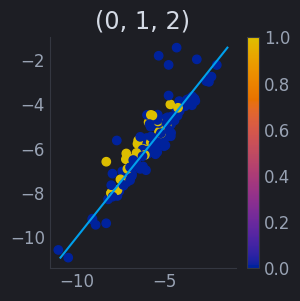

In [25]:
mod_params = jax.tree.map(lambda x: None, params)

def normalize_weights(w):
    return w / (w.shape[0] ** 0.5)

def normalize_weights1(w):
    return w

mod_params['params']['edge_embedding']['basis']['freq'] = ckpt['edge_embedding.basis_function.coeffs']
mod_params['params']['node_embedding']['embed']['embedding'] = jnp.concat((
    jnp.zeros((1, 128)),
    normalize_weights(ckpt['onehot_to_feature_x.linear.weight'].reshape(89, 128))[z_conversion]
), axis=0)
mod_params['params']['head']['Dense_0']['kernel'] = normalize_weights(ckpt['reduce_input_to_hidden.linear.weight'].reshape(128, 64))
mod_params['params']['head']['Dense_1']['kernel'] = normalize_weights(ckpt['reduce_hidden_to_energy.linear.weight'].reshape(64, 1))
mod_params['params']['rescale']['scale'] = jnp.concat((jnp.zeros((1,)), ckpt['rescale_atomic_energy.scale'][z_conversion]))
mod_params['params']['rescale']['shift'] = jnp.concat((jnp.zeros((1,)), ckpt['rescale_atomic_energy.shift'][z_conversion]))


from itertools import permutations

perms = sorted(permutations(range(3)))

for perm in perms[:1]:
    for layer_i in range(5):
        layer = {k.removeprefix(f'{layer_i}_'): v for k, v in ckpt.items() if k.startswith(f'{layer_i}_') and v.size > 0}

        mod_layer = params['params']['mace'][f'layer_{layer_i}']['interaction']
        layer_params = mod_params['params']['mace'][f'layer_{layer_i}']['interaction']
        for i in (0, 1, 2):
            w = normalize_weights(layer[f'convolution.weight_nn.layer{i}.weight'])
            # if i == 2:
            #     w *= config.data.metadata.avg_num_neighbors(5.0) / 35.9
            layer_params['SimpleInteraction_0']['SevenNetConv_0']['LazyInMLP_0'][f'Dense_{i}']['kernel'] = w

        def recombine(W, path, normalize_path=False):
            norm_fn = normalize_weights if normalize_path else normalize_weights1
            shapes = path(mod_layer)
            out = path(layer_params)
            # items = sorted(shapes.items(), key=lambda kv: kv[0][len('w[0,')])       
            items = list(shapes.items())  
            # items = sorted(shapes.items())
            # print([k for k, v in items])
            if len(items) == len(perm):
                items = [items[i] for i in perm]
            for k, v in items:
                v1 = W[:v.size].reshape(v.shape[::-1]).T
                v2 = W[:v.size].reshape(v.shape)
                out[k] = v2
                out[k] = norm_fn(out[k])
                W = W[v.size:]

            assert W.size == 0
            
        recombine(layer['self_connection_intro.linear.weight'], lambda x: x['resid_adapter'])
        recombine(layer['self_interaction_2.linear.weight'], lambda x: x['SimpleInteraction_0']['linear_outro'])
        recombine(layer['self_interaction_1.linear.weight'], lambda x: x['SimpleInteraction_0']['linear_intro'])

    out = model.apply(mod_params, cg=cg, ctx=Context(training=False))
    yhat = out[cg.padding_mask].reshape(-1)
    na = cg.n_node[cg.padding_mask]    
    y = cg.target_data.e_form[cg.padding_mask].reshape(-1)

    gga_u_mask = np.array([d.endswith('+U') for d in data_ids])

    err = jnp.mean(jnp.abs(y - yhat)[gga_u_mask])

    print(err)
    if err > 1.3:
        continue

    fig, ax = plt.subplots(figsize=(3, 3))
    plt.scatter(yhat, y, c=[d.endswith('+U') for d in data_ids])
    plt.colorbar()
    plt.plot(sorted(y), sorted(y));
    plt.title(str(perm))
# debug_structure(mod_params);


[
]

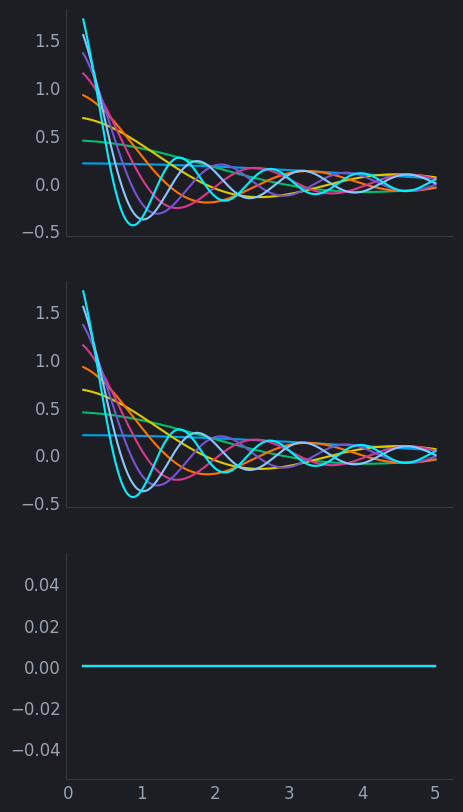

In [26]:
from facet.mace.edge_embedding import SincBasis

bound = model.bind(mod_params)

basis = bound.mace.radial_embedding.basis

new_params = {'params': mod_params['params']['edge_embedding']['basis'].copy()}
new_params['params']['freq'] = new_params['params']['freq']
basis2 = SincBasis(8, True).bind(new_params)

rr = jnp.linspace(0.2, 5, 1000)

yy = basis(rr, 5.0, ctx=Context(training=False))
yy2 = basis2(rr, 5.0, ctx=Context(training=False))

fig, axs = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
axs[0].plot(rr, yy)
axs[1].plot(rr, yy2);
axs[2].plot(rr, yy - yy2)

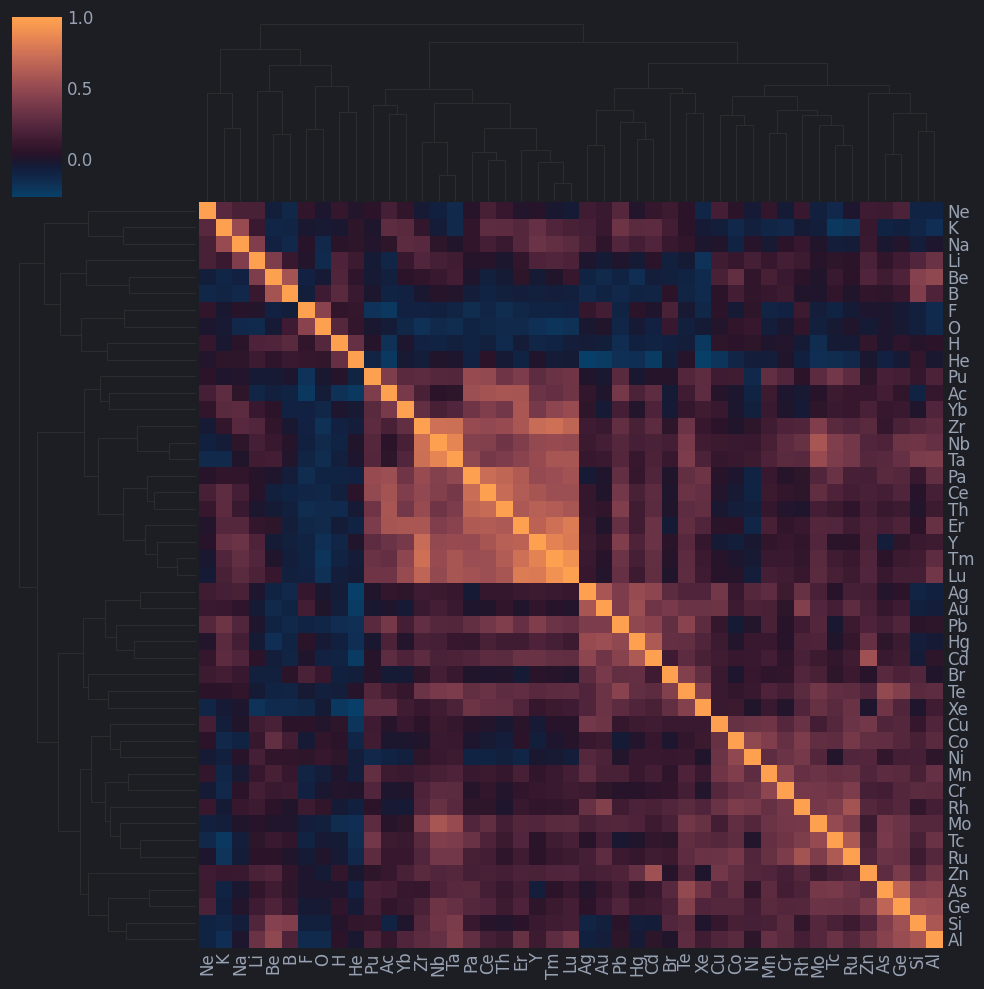

In [27]:
ne = mod_params['params']['node_embedding']['embed']['embedding']
ne_corr = np.corrcoef(ne + 1e-6 * np.random.randn(*ne.shape))
inds = np.arange(ne_corr.shape[0])[1::2]
syms = np.array(config.data.metadata.symbols)[inds]
sns.clustermap(ne_corr[inds][:, inds], yticklabels=syms, xticklabels=syms,
center=0, cmap='rho_diverging');

In [28]:
from facet.flow_viz import visualize_model_flow

visualize_model_flow(config, mod_params, True, False)

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

In [17]:
from facet.utils import save_pytree

save_pytree(mod_params, 'precomputed/sevennet.ckpt')